# TV Series Duration Prediction
# Aditya Sai
# January 18, 2021

## Background

We all have our TV series, but what makes them last, season after season? Various factors may explain their success and staying power, including:
- a catchy title 
- a convincing cast tailor-made for their roles 
- a compelling plot with a narrative structure that resonates with the audience (comedies, dramas, documentaries, etc.) 
- a movie-like budget that escalates with every season, resulting sometimes with a sudden announcement that the series is going to end
- runtimes that should keep the audience interested for just the right amount of time, but always wanting more 
- ratings from critics and average viewers alike, including social media impressions

There is no doubt that these factors drive content creators and distributors in their decision-making about which new series to pursue. Of course, with the advent of streaming platforms, the amount of data they have access to has more volume, variety, and velocity to it than ever before. 

I personally have always been intrigued by what determines the duration of TV series, so this exercise was my attempt at trying to understand those factors. Specifically, I downloaded the [IMDB](https://www.imdb.com/interfaces/) dataset. This daily refreshed TSV dataset contains information about hundreds of thousands of TV series, along with the number of seasons they ran for. I set out to predict the number of seasons each TV series ran for using other information contained within the dataset. Along the way, I also want to take an opportunity to implement a novel technique in deep learning known as [reverse distillation](https://arxiv.org/abs/2007.05611), which I was involved in validating, to improve model performance. 


## PART 1: Import relevant libraries & datasets
First, I imported relevant libraries and read in the base dataset I will be building my classifier with. I also imported a file called `helpers.py` that contains some helper functions I assembled into a function. FYI, I also included the [Python script]() I used to generate this base dataset in the project repository.  

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

# Import relevant libraries for dataset preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import *

# Read in source (pre-processed) dataset
df = pd.read_csv("base_data.csv", index_col='tconst')

# Return length of dataset
len(df)

101685

In [2]:
# Peek at source dataset schema
df.head()

,originalTitle,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,seasonNumber,episodeNumber,uniqueOrderings,uniqueTitles,uniqueRegions,uniqueTypes,uniqueLanguages,uniqueAttributes,isOriginalTitle,languagePrediction,languageProbability
tconst,,,,,,,,,,,,,,,,,,
tt0032557,The Green Archer,1940,NaN,285.0,"Action,Adventure,Crime",6.4,131.0,1.0,15.0,7.0,5.0,6.0,3.0,4.0,1.0,1.0,en,0.999877
tt0039120,Americana,1947,1949.0,30.0,"Family,Game-Show",3.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,es,0.400063
tt0039122,The Borden Show,1947,NaN,30.0,"Comedy,Music",NaN,NaN,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,en,0.686560
tt0039123,Kraft Television Theatre,1947,1958.0,60.0,Drama,8.6,127.0,11.0,587.0,4.0,4.0,3.0,3.0,2.0,2.0,1.0,en,0.996839
tt0039125,Public Prosecutor,1947,1951.0,20.0,"Crime,Drama,Mystery",5.9,7.0,1.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,en,0.619047


I wanted to briefly explain some of the columns in this base dataset of over 100,000 TV series. 
1. **originalTitle**: Original title of the TV series
2. **startYear** and **endYear** are the years during which the TV series was running
3. **runtimeMinutes** was the number of minutes each episode of the TV series ran for
4. **genres**: IMDB listed at most 3 genres for each TV show
5. **averageRating** and **numVotes** provide rating information
6. **seasonNumber** and **episodeNumber** list the total number of seasons and episodes for that TV series
7. **uniqueOrderings** through **uniqueAttributes** provide metadata pertaining to international & alternative distributions of the TV series
8. **isOriginalTitle** is a boolean column indicating whether the **originalTitle** is the true original title of the TV series.
9. **languagePrediction** and **languageProbability** are additional predictor columns obtained by using the [LangID Python module](https://github.com/saffsd/langid.py) to predict the language and confidence level of the **originalTitle** column

From this summary view, it is easy to see that there were columns with missing (**endYear**, **averageRating**, **numVotes**) and non-uniform (**genres**) values. Next, I show how I processed this dataset with feature engineering. The final feature set was derived from the columns presented here.  

## PART 2: Engineer preliminary set of features (binning -> dummy encoding, etc.)
With this preliminary set of columns, I started engineering features by first separating the genre column (using the comma delimiter into 3 columns). From what I understand about the dataset, the genre column is unordered, so what is listed as the first genre is equally as informative as the third genre. However, many TV series are missing a second or third genre, which is resolved by imputing the genre with **None**. The resulting 3 genre columns are converted to categorical format. I also convert the quantitative columns to numeric based, forcing missing values to be stored as `nan`. 

In [3]:
results = df.copy()

# Split genre column of lists into 3 separate columns
results.loc[:,['genre1','genre2','genre3']] = results['genres'].str.split(',').apply(pd.Series).rename(columns={0:'genre1',1:'genre2',2:'genre3'}) 

# Fill in alternate genre columns and convert to category
results[['genre1','genre2','genre3']] = results[['genre1','genre2','genre3']].fillna('None').astype('category')

# Convert quantitative columns to numeric
num_cols = ['startYear','endYear','runtimeMinutes','averageRating',
            'numVotes','seasonNumber','episodeNumber']
results.loc[:,num_cols] = results.loc[:,num_cols].apply(pd.to_numeric, errors='coerce')


For the remaining columns, rather than trying to impute `nan` values in all columns, I assumed that the `nan` value itself was informative by binning these columns with a separate bin in place for `nan` values. Once bin edges were defined for each column, I ran `pd.cut` to discretize the numeric columns. 

A special case of the binning process is the **languagePrediction** column, from which I extracted 5 binary columns based on the 5 most frequently predicted languages for this dataset: English, Spanish, German, French, Italian. These 5 languages alone cover nearly 75% of all the predicted languages, so I achieved good predicted language coverage with these features. Finally, I used the `pd.get_dummies` to dummy-encode categorical columns with more than 2 categories, dropping the first categorical column due to multicollinearity. 

In [4]:
# Bucketize features into distinct categories based on non-NaN values
# Create separate features for NaN values 
results['startYear'], startYearBins = pd.qcut(results['startYear'], q=20, 
                               duplicates='drop', labels=False,
                               retbins=True)
results['startYear'] = results['startYear'].astype(int)
results['runtimeMinutes'] = pd.cut(results['runtimeMinutes'].fillna(-1),
                                   bins=[-1, 0, 30, 60, 10000], 
                                   labels=False, include_lowest=True).astype(int)
results['averageRating'] = pd.cut(results['averageRating'].fillna(-1),
                                  bins=[-1, 0, 6, 7, 8, 11], 
                                  labels=False, include_lowest=True).astype(int)
results['numVotes'] = pd.cut(results['numVotes'].fillna(0),
                             bins=[0, 10, 100, 2000000], 
                             labels=False, include_lowest=True).astype(int)
results['uniqueOrderings'] = pd.cut(results['uniqueOrderings'].fillna(1),
                                      bins=[1, 2, 4, 1e10],
                                      labels=False, include_lowest=True).astype(int)
results['uniqueTitles'] = pd.cut(results['uniqueTitles'].fillna(1),
                                  bins=[1, 2, 3, 1e10],
                                  labels=False, include_lowest=True).astype(int)
results['uniqueRegions'] = pd.cut(results['uniqueRegions'].fillna(1),
                                  bins=[1, 4, 1e10],
                                  labels=False, include_lowest=True).astype(int)
results['uniqueTypes'] = pd.cut(results['uniqueTypes'].fillna(1),
                                bins=[1, 2, 3, 1e10],
                                labels=False, include_lowest=True).astype(int)
results['uniqueLanguages'] = (results['uniqueLanguages'] > 1).astype(int)
results['uniqueAttributes'] = (results['uniqueAttributes'] > 1).astype(int)
results['isOriginalTitle'] = results['isOriginalTitle'].fillna(0).astype(int)
results['isEnglish'] = results.apply(
    lambda x: 1 if x['languagePrediction'] == 'en' else 0,
    axis = 1
    )
results['isSpanish'] = results.apply(
    lambda x: 1 if x['languagePrediction'] == 'es' else 0,
    axis = 1
    )
results['isGerman'] = results.apply(
    lambda x: 1 if x['languagePrediction'] == 'de' else 0,
    axis = 1
    )
results['isFrench'] = results.apply(
    lambda x: 1 if x['languagePrediction'] == 'fr' else 0,
    axis = 1
    )
results['isItalian'] = results.apply(
    lambda x: 1 if x['languagePrediction'] == 'it' else 0,
    axis = 1
    )
results = pd.get_dummies(results,
                         columns=['uniqueOrderings','uniqueTitles','uniqueRegions','uniqueTypes',
                                  'startYear','runtimeMinutes','averageRating','numVotes',
                                  'genre1','genre2','genre3'],
                         drop_first=True)

## PART 3: Define (multiclass) target outcome to predict
For this multiclass classification task, I define the target outcome as follows:

| Outcome | Condition | Meaning |
| :-----------: | -----------: | ------: |
| **0** | **seasonNumber** == 1 | *short-term* TV series of 1 season |
| **1** | 2 <= **seasonNumber** <= 4 | *medium-term* TV series of 2-4 seasons | 
| **2** | otherwise | *long-term* TV series of at least 5 seasons |

I was particularly interested in the model performance with respect to the final category. Long-term TV series are fairly infrequent and the predictors for that particular category may lend some insight into what sustains a TV series. 

As the plot below shows, nearly 2 out of 3 TV series in this dataset did not last beyond 1 season. Furthermore, less than a quarter ended before 5 seasons. This is clearly an imbalanced multiclass classification task. 



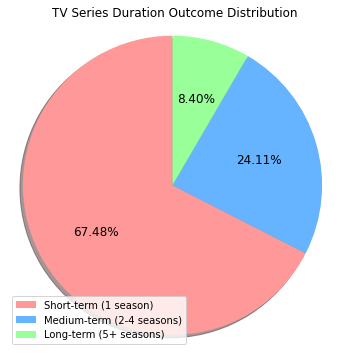

In [5]:
results['target'] = pd.cut(results['seasonNumber'],bins=[1, 2, 5, 10000], 
                           labels=False, right=False, include_lowest=True).astype(int)

labels = ['Short-term (1 season)', 'Medium-term (2-4 seasons)', 'Long-term (5+ seasons)']
prevalences = results.target.value_counts(normalize=True,sort=False).tolist()

# Plot outcome distributions related to multiclass problem
plot_outcome_distribution(labels,prevalences)

## PART 4: Split dataset into (training, validation, test)
After dropping irrelevant columns like the **endYear** and **seasonNumber** columns, I split the dataset into training, validation, and test sets, using a 60-20-20 split. 

In [6]:
# Define outcome (Y) & predictors (X)
Y = results['target']
# Keep all numeric columns (and tv series title)
X = results.drop(columns=['endYear','genres','seasonNumber','episodeNumber',
                          'languagePrediction','target'])

# Compute class weights for imbalanced datasets
from sklearn.utils.class_weight import compute_class_weight

class_weight_dic = dict(enumerate(compute_class_weight(class_weight='balanced',
                                                       classes=np.unique(Y),
                                                       y=Y)))    
    
# Train-val-test split
from sklearn.model_selection import train_test_split
indices_all = range(len(X))
# First split into training and test (80-20)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, Y, indices_all, test_size=0.2, 
                                                                                 random_state=0, stratify=Y)
# Next split into training and validation (75-25)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, indices_train,
                                                                              test_size=0.25, random_state=0, stratify=y_train)


## PART 5: Preprocess titles of TV series & add additional Bag of Words (BOW) features
I added additional BOW features from a corpus composed of the **originalTitle** column mentioned before. I added these features after the dataset was split, so that data leakage did not occur. The actual corpus preprocessing steps I used are available in [helpers.py](). I wanted 1,024 total features, so I only needed 1,024 - 118 = 906 features from this step. I applied the CountVectorizer to the training set, and then generalized to the validation and test sets. 

My purpose in using BOW features derived from the titles was to incorporate the most frequently encountered stemmed terms beyond what language they were predicted to be in. Using binary indicators of the most prevalent terms composing these titles would hopefully provide additional lift in model performance. 

In [7]:
# Preprocess training, validation, and test corpora    
corpus_train = preprocess_corpus(X_train.loc[:,'originalTitle'])
corpus_val = preprocess_corpus(X_val.loc[:,'originalTitle'])
corpus_test = preprocess_corpus(X_test.loc[:,'originalTitle'])

# Compute BOW representation
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=False, ngram_range=(1,1), strip_accents='ascii', max_features=1024-118, binary=True)

# Fit & Transform training data, then transform validation and test data
X_train_bow = cv.fit_transform(corpus_train)
X_val_bow = cv.transform(corpus_val)
X_test_bow = cv.transform(corpus_test)    

# Concatenate and convert to sparse matrix format
X_train_final = combine_sparse_data(X_train.drop(columns=['originalTitle']).astype('float64'), X_train_bow)
X_val_final = combine_sparse_data(X_val.drop(columns=['originalTitle']).astype('float64'), X_val_bow)
X_test_final = combine_sparse_data(X_test.drop(columns=['originalTitle']).astype('float64'), X_test_bow)


## PART 6: Train multi-class logistic regression classifier on TV series data
With the feature set now defined, I trained a simple linear model (aka a multinomial logistic regression classifier) to predict the TV series' duration categories. I explored different hyperparameters for the regularization penalty in L1 regularization. These hyperparamter values were searched for on a logarithmic scale, with the hyperparameter value leading to the maximum AUC on the validation set being selected. Finally, I reported the test set performance using the optimal model. 

The version of the AUC score I used for this exercise was a weighted one-versus-rest AUC. I also reported the balanced accuracy score, which adjusts the actual accuracy to account for class imbalance. 

----VALIDATION PERFORMANCE----
Lambda = 20
Logistic Regression Validation AUC: 0.6934
Logistic Regression Validation Balanced Accuracy: 0.5288
Lambda = 2
Logistic Regression Validation AUC: 0.6968
Logistic Regression Validation Balanced Accuracy: 0.5321
Lambda = 0.2
Logistic Regression Validation AUC: 0.7025
Logistic Regression Validation Balanced Accuracy: 0.5465
Lambda = 0.02
Logistic Regression Validation AUC: 0.6928
Logistic Regression Validation Balanced Accuracy: 0.5339
Lambda = 0.002
Logistic Regression Validation AUC: 0.6583
Logistic Regression Validation Balanced Accuracy: 0.4720
Lambda = 0.0002
Logistic Regression Validation AUC: 0.5000
Logistic Regression Validation Balanced Accuracy: 0.3333
----TEST PERFORMANCE----
Logistic Regression Test AUC: 0.7001
Logistic Regression Test Balanced Accuracy: 0.5417


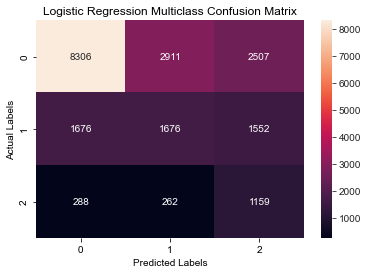

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Iterate through each value of regularization hyperparameter and record validation accuracy
reg_lambdas = [20, 2, 0.2, 0.02, 0.002, 0.0002]
lr_val_aucs = [] 
lr_val_accs = []
print('----VALIDATION PERFORMANCE----')
for reg_lambda in reg_lambdas:
    clf_lr = LogisticRegression(solver = 'saga',
                                class_weight = 'balanced',
                                max_iter = 100,
                                multi_class = 'multinomial',
                                penalty='l1',
                                C=reg_lambda,
                                random_state=0)
    clf_lr.fit(X_train_final,y_train)
    prob_lr = clf_lr.predict_proba(X_val_final)
    pred_lr = clf_lr.predict(X_val_final)
    lr_val_aucs.append(roc_auc_score(y_val, prob_lr, average='weighted', multi_class='ovr'))
    lr_val_accs.append(balanced_accuracy_score(y_val, pred_lr))
    print('Lambda = {}'.format(reg_lambda))
    print('Logistic Regression Validation AUC: {0:.4f}'.format(roc_auc_score(y_val, prob_lr, average='weighted', multi_class='ovr')))
    print('Logistic Regression Validation Balanced Accuracy: {0:.4f}'.format(balanced_accuracy_score(y_val, pred_lr)))

# Select optimal model with maximum validation accuracy
clf_lr = LogisticRegression(solver = 'saga',
                            class_weight = 'balanced',
                            max_iter = 100,
                            multi_class = 'multinomial',
                            penalty='l1',
                            C=reg_lambdas[np.argmax(lr_val_aucs)],
                            random_state=0)
clf_lr.fit(X_train_final, y_train)

print('----TEST PERFORMANCE----')
report_test_performance_multiclass(clf_lr,X_test_final,y_test,'Logistic Regression')
rd_train = clf_lr.predict_proba(X_train_final)
rd_val = clf_lr.predict_proba(X_val_final)
rd_test = clf_lr.predict_proba(X_test_final)

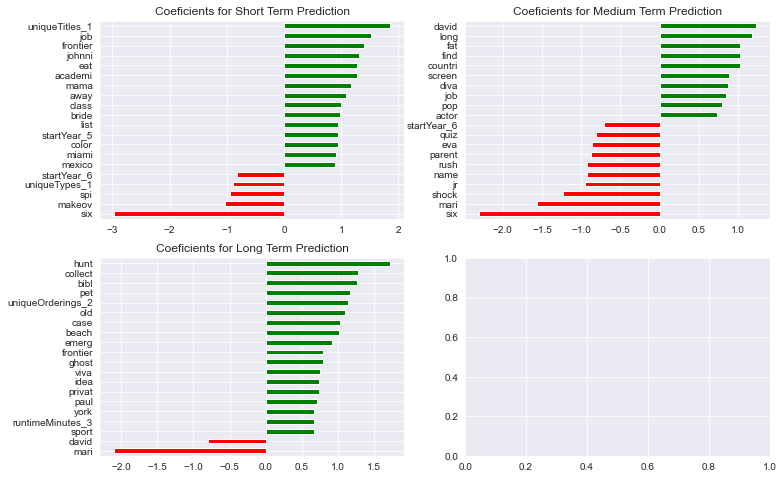

In [9]:
coefs = pd.DataFrame(clf_lr.coef_.reshape(-1,3),
                     columns=['coef0', 'coef1', 'coef2'],
                     index=X_train.columns[1:].tolist() + list(cv.vocabulary_.keys()))

plot_coefficients(coefs)

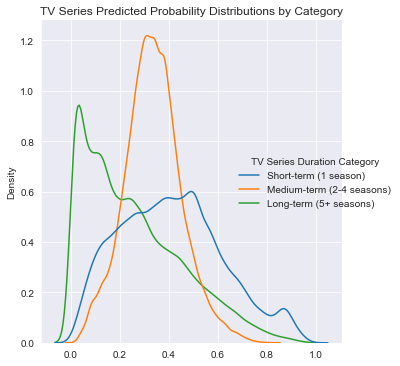

In [10]:
rd_train = clf_lr.predict_proba(X_train_final)
plot_probabilities(rd_train,labels)

So PART 6 shows that its possible to get a decent classifier with a test AUC of 0.7 and a balanced accuracy of around 54%. Furthermore, the confusion matrix showed that the medium term TV series were the most difficult to predict, where there is fairly low recall and precision. The other 2 classes showed improved performance relative to the medium term. Intuitively, this would make sense because there may be some factors that can easily determine whether something lies at the extremes of this artificial distribution and labeling, but to determine those instances that lie in the middle would be more challenging. In other words, it may be relatively easy to determine complete hits or misses, but something in between, like what I have defined as medium term, may not be as readily distinguishable. 

The next graphic shows the regression coefficients for the multiclass logistic regresion model. This bar plot show positive coefficients for those features that are more likely to predict that outcome in green, and negative coefficients for those features that are more likely to predict the complimentary outcome in red. 
1. For short-term TV series, having 3 **uniqueTitles** and the terms *job* and *frontier* are most indicative of lasting only 1 season, whereas the term *six* suggests something that lasts beyond 1 season. 
2. For medium-term TV series, the majority of impactful features center around terms. Again the term *six* suggests something that is not a medium-term TV series. 
3. For long-term TV series, having at least 4 **uniqueOrderings** hints at a series' staying power. The stemmed term *mari* predicts TV series lasting less than 5 seasons. 

Probability distributions likewise showed significant differences. Short-term TV series had a lower peak and a deformed normal distribution centered around 0.5. The medium-term distribution appeared normally distributed, but had a mean around 0.35 to 0.4. The long-term distribution had a lower prevalence, so it appeared heavily right skewed as it required more evidence to label a TV series as being long term.  

## PART 7: Implement Reverse Distillation
Now that I was able to build a linear model to predict TV series duration, I wanted to tackle the same task using deep learning. Recently, I was part of a [publication](https://arxiv.org/abs/2007.05611) co-authored with researchers from MIT that tried to initialize deep learning models for clinical event prediction using a paradigm known as reverse distillation. In reverse distillation, a linear model, like the logistic regression model I trained earlier, could distill its knowledge up to a neural network, as a form of teacher to student knowledge transfer. This distillation process serves as a form of pretraining that initializes the neural network with a configuration that should match the linear model in its predicted probability space. With this initialization, the neural network was found to have higher performance compared to training without reverse distillation across several clinical prediction tasks. 

In this situation, I attempted a reverse distillation exercise for multiclass classification, something that was not attempted previously. I had doubts as to whether it would work in this context mainly due to the quality of the feature set. In any case, my approach involved Keras models that were fit with callback functions. These callback functions  both reduced the learning rate upon plateauing of the validation loss for 3 epochs, and executed early stopping once the validation loss did not improve for 5 epochs. I saved the weights of the network corresponding to the epoch with the lowest validation loss. 

As for the models themselves, I used a fully-connected network with 9 hidden layers that progressively halve in dimensionality to a final dense layer with 3 output units. The activations for each layer used the rectified linear unit (ReLU), with the exception of the final layer, which had a softmax activation. 

There are 2 phases to the training process:
1. **Pre-training using Reverse Distillation**: I trained in batches of 1000 instances for 50 epochs with a learning rate of 0.1. The loss function used was a categorical cross-entropy function where the targets were the predicted class probabilities of the linear model. Reverse distillation requires the neural network to approximate the probability distributions predicted by the linear model. 
2. **Fine-tuning**: I trained in batches of 50 instances for 20 epochs with a learning rate of 1e-6. The loss function used was a sparse categorical cross-entropy function where the targets were the actual labels denoting the duration category of that instance. This phase made minor adjustments to the weights of the neural network so the model could adjust to the ground truth labels and did not rely solely on the linear model. 

I compared a model that underwent both reverse distillation and fine-tuning against a baseline model that was only fine-tuned, as in the publication. My goal was to observe if the results in our publication still held for relatively shallow datasets like TV series dataset where complex layers like multi-headed self attention and convolution were not necessary. 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Reverse Distillation Test AUC: 0.6999
Reverse Distillation Test Balanced Accuracy: 0.5414


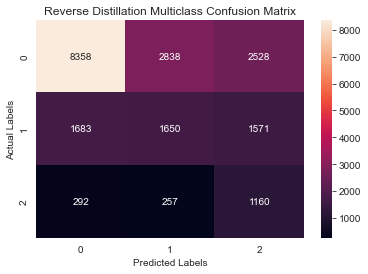

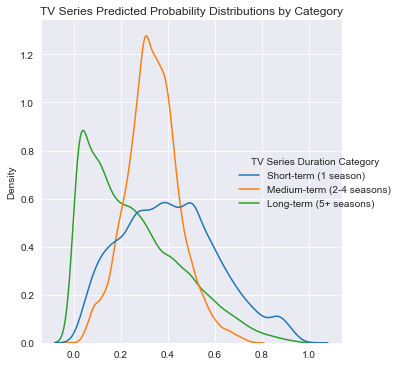

In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define appropriate callbacks
early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=0,
                                       mode='auto',
                                       baseline=None,
                                       restore_best_weights=True)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience=3, 
                                   verbose=0, 
                                   mode='min')

# TEST 1: Reverse Distillation
RDclassifier = ANNMultiClassifierModel()

RDclassifier.compile(optimizer=Adam(lr=1e-1),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

# Pretraining using reverse distillation (use class weights)
RDclassifier.fit(X_train_final.toarray(), rd_train,
                 validation_data=(X_val_final.toarray(), rd_val),
                 batch_size=1000,
                 epochs=50,
                 callbacks=[early_stopping_monitor, reduce_lr_loss],
                 verbose=0)

# Predict test set performance
report_test_performance_multiclass(RDclassifier,X_test_final.toarray(),y_test,'Reverse Distillation')

# Plot predicted probabilities
plot_probabilities(RDclassifier.predict(X_test_final.toarray()),labels)


Fine Tuning Test AUC: 0.6999
Fine Tuning Test Balanced Accuracy: 0.5414


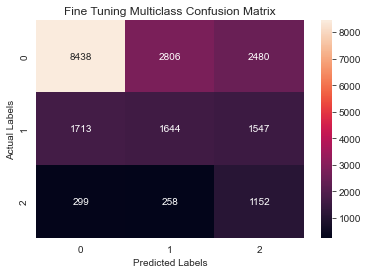

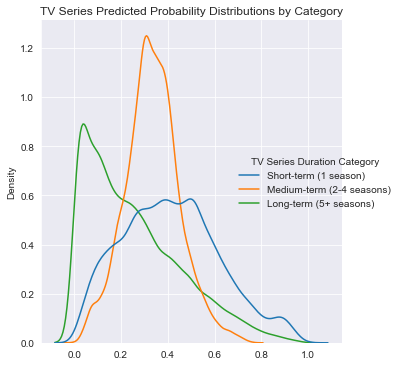

In [12]:
# TEST 2: Fine Tuning
RDclassifier.compile(optimizer = Adam(lr=1e-6), 
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                   weighted_metrics = ['accuracy'])


# Fine-tuning (use class weights)
RDclassifier.fit(X_train_final.toarray(), y_train,
                 validation_data=(X_val_final.toarray(), y_val),
                 batch_size = 50, 
                 epochs = 20,
                 callbacks=[early_stopping_monitor,reduce_lr_loss],
                 class_weight=class_weight_dic,
                 verbose=0)

# Predict test set performance
report_test_performance_multiclass(RDclassifier,X_test_final.toarray(),y_test,'Fine Tuning')

# Plot predicted probabilities
plot_probabilities(RDclassifier.predict(X_test_final.toarray()),labels)


Baseline ANN Test AUC: 0.6570
Baseline ANN Test Balanced Accuracy: 0.4710


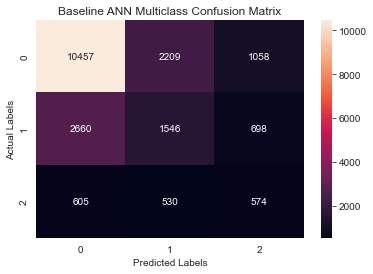

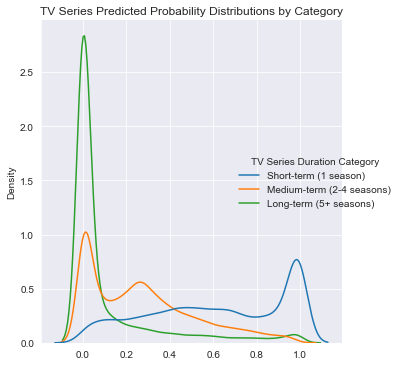

In [13]:
# TEST 3: Baseline Approach
classifier = ANNMultiClassifierModel()

classifier.compile(optimizer=Adam(lr=1e-1),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   weighted_metrics=['accuracy'])

classifier.fit(X_train_final.toarray(), y_train,
               validation_data=(X_val_final.toarray(), y_val),
               batch_size=1000,
               epochs=50,
               callbacks=[early_stopping_monitor, reduce_lr_loss],
               class_weight=class_weight_dic,
               verbose=0)

# Predict test set performance
report_test_performance_multiclass(classifier,X_test_final.toarray(),y_test,'Baseline ANN')

plot_probabilities(classifier.predict(X_test_final.toarray()),labels)

So the results were somewhat mixed, which is to be expected with a somewhat experimental procedure like reverse distillation. Reverse distillation and fine-tuning did not lead to any gain in the AUC. However, training the neural network from scratch, with no input from reverse distillation, seemed to degrade performance completely, not even keeping pace with the linear model. Some possible reasons for this may be that the baseline model may not have had an appropriate level of regularization that would serve as a form of soft feature selection, whereas reverse distillation implicitly relayed this information to the neural network in the form of predicted probabilities of the linear model. Without reverse distillation, the network was forced to learn an immature version of feature selection that led to suboptimal, possibly greedy solutions. Most importantly though, I found that reverse distillation, and even the underlying logistic regression model, outperformed the baseline ANN approach with an increase of the test AUC of approximately **6.5%**. 

If we look at the class-specific precision and recall scores across the different models, interesting insights emerge:

| Model       | Short-term     | Short-term  | Medium-term | Medium-term | Long-term | Long-term |
| ----------- | ----------- | ----- | ------- | - | ------ | ------- | 
| - | Precision   | Recall | Precision | Recall | Precision | Recall |
| Logistic Regression | 0.809 | 0.605 | 0.346 | 0.342 | 0.222 | 0.678 |
| Reverse Distillation | 0.809 | 0.609 | 0.348 | 0.336 | 0.221 | 0.679 |
| Fine Tuning | 0.807 | 0.615 | 0.349 | 0.335 | 0.222 | 0.674 |
| Baseline   | 0.762 | 0.762 | 0.361 | 0.315 | 0.246 | 0.336 |

The logistic regression, reverse distillation, and fine tuned models all appear to have similar precision and recall values across all 3 classes. From short-term to long-term, these models sacrifice high precision for slightly higher recall, while the medium-term represents an overall nadir in performance. **Reverse distillation was successful in transferring knowledge from a simple linear model to its more complex counterpart, as evidenced by the identical probability distributions and performance metrics.** In general, this trend of increased recall as the target prevalence decreases is not unexpected. It would appear as if these models were fairly liberal in their predictions of long-term TV series, willing to tolerate a high number of false positives to capture as many actual long-term TV series as possible.

On the other hand, the baseline model appears to take a completely different performance trajectory. Looking at its recall at long-term predictions, it drops by nearly half, as its short-term recall goes up. This tradeoff can also be reflected in the probability plots. The baseline model seems to learn a poorly calibrated distribution across the 3 classes. Its long-term distribution is extremely unimodal and right-skewed compared to the other models. The medium-term distribution is uniquely bimodal, while its short-term distribution is significantly left-skewed. It was actually able to correctly classify more short-term instances, but was confounded at long-term predictions. In fact, it distributed all actual long-term instances into the 3 duration categories fairly equally, in spite of the increased class penalty assigned to this subset of data.  

## Takeaways

> **The majority of TV series never make it beyond 1 season.**


If the dataset presented here is to be any indication of the real world at large, 2 out of 3 TV series are discontinued after the first season, if they can even make it to the end of the first season. The features presented here that are suggestive of short-term vs non short-term success may be artifacts of this particular dataset, so any generalizations to the present or future TV series should be considered with some doubt. Nevertheless, I was able to show certain terms contained within the titles of TV series do resonate with the target outcomes designed here. 

> **Reverse distillation outperforms a baseline model in terms of AUC, even in a multiclass context.** 

Knowledge transfer is an important tool in machine learning. It has shown great promise in designing SOTA models in critical domain areas. I was able to demonstrate that reverse distillation resulted in a model with an improved test AUC compared to a baseline model that initialized its weights from scratch. Moreover, I was able to do so in a multiclass classification context with fairly shallow features. From what I understand, the multinomial loss used in the multiclass logistic regression model is the same as the categorical cross-entropy function used for the baseline neural network. However, both approaches led to divergent probability distributions that emphasized different aspects of the classification task. The reverse distillation approach led to unimodal, more entropic distributions, while the baseline approach contained multiple extreme modes for the short and medium-term classes. Likewise, the reverse distillation approach maximized the long-term recall (a lower prevalence target), while the baseline approach maximized the short-term recall (a higher prevalence target). However, when it comes to balanced accuracy, the reverse distillation approach had a balanced accuracy above 50%, while the baseline approach failed to reach 50%. So while I was unsuccessful in demonstrating that reverse distillation improved performance over the linear model, I was able to show it did improve performance over a baseline neural network. 

As for next steps, I could look into the following:
1. **Replace the targets for reverse distillation**: Instead of using the predicted probabilities from the linear model, I could have used the logits instead. Probabilities for certain classes may become so low that they have no influence on the cross-entropy loss function. However, the corresponding logits may guide the distilled model better towards exploiting additional information about the similarity structure of instances across classes. 
2. **Modify the loss function for fine-tuning**: In this project, I did not incorporate additional information about reverse distillation in the fine-tuning process. Specifically, I could have added the reverse distillation loss to the fine-tuning loss, as in the MIT publication. 
3. **Replace the linear model for reverse distillation**: I was also interested in looking into initializing the reverse distillation processes with other, possibly non-linear models, but found no immediate success. Its possible tree-based classifiers, ensemble classifiers (bagging, boosting, stacking, classifier chains, etc.), or even reframing the problem in a multilabel context would lead to different conclusions and insights than those gleaned here. 